# imbalanced-learn

[imbalanced-learn](https://imbalanced-learn.org) is a package to deal with imbalance in data. The data imbalance typically manifest when you have data with class labels, and one or more of these classes suffers from having too few examples to learn from. 

## Data generation

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd

plt.style.use('ggplot')
np.random.seed(37)

X, y = make_classification(**{
    'n_samples': 5000,
    'n_features': 5,
    'n_classes': 2,
    'random_state': 37
})

columns = [f'x{i}' for i in range(X.shape[1])] + ['y']
df = pd.DataFrame(np.hstack([X, y.reshape(-1, 1)]), columns=columns)

print(df.shape)

(5000, 6)


In [2]:
df.head()

,x0,x1,x2,x3,x4,y
0,-0.729402,0.390517,-0.603771,0.286312,-0.266412,0.0
1,0.030495,-0.970299,1.223902,-0.343972,-0.479884,0.0
2,-0.657696,-0.811643,-1.075159,0.405169,-0.022806,0.0
3,0.138540,2.012018,-1.825350,0.482964,0.845321,1.0
4,2.231350,-0.705512,-0.453736,-0.238611,1.757486,1.0


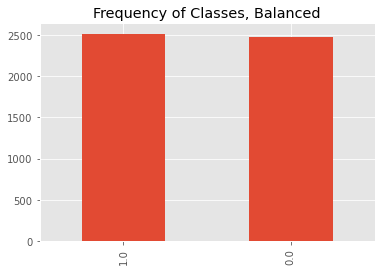

In [3]:
ax = df.y.value_counts().plot(kind='bar')
_ = ax.set_title('Frequency of Classes, Balanced')

## Class imbalance

In [4]:
df0 = df[df.y == 0].copy(deep=True).reset_index(drop=True)
df1 = df[df.y == 1].sample(frac=0.01).copy(deep=True).reset_index(drop=True)

df = pd.concat([df0, df1])

In [5]:
df.shape

(2508, 6)

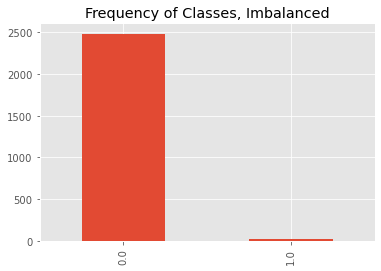

In [6]:
ax = df.y.value_counts().plot(kind='bar')
_ = ax.set_title('Frequency of Classes, Imbalanced')

## Learning with class imbalance

In [7]:
X = df[[c for c in df.columns if c != 'y']]
y = df.y

print(X.shape, y.shape)

(2508, 5) (2508,)


In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=37)

rdf = []
for fold, (tr, te) in enumerate(skf.split(X, y)):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]
    
    model = LogisticRegression(penalty='l2', solver='liblinear', random_state=37)
    model = RandomForestClassifier(n_jobs=-1, random_state=37)
    model.fit(X_tr, y_tr)
    y_pr = model.predict_proba(X_te)[:,1]
    
    auc = roc_auc_score(y_te, y_pr)
    aps = average_precision_score(y_te, y_pr)
    
    rdf.append({'auc': auc, 'aps': aps})
    
rdf = pd.DataFrame(rdf)

In [18]:
rdf[['auc', 'aps']].agg(['mean', 'std'])

,auc,aps
mean,0.972218,0.750400
std,0.080609,0.305972


## Oversampling

In [61]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from sklearn.cluster import KMeans
from collections import Counter
from itertools import chain

def get_oversampler(sampler):
    if 'adasyn' == sampler:
        p = {
            'random_state': 37,
            'n_neighbors': 5
        }
        return ADASYN(**p)
    elif 'borderlinesmote' == sampler:
        p = {
            'random_state': 37,
            'n_jobs': -1,
            'k_neighbors': 5,
            'm_neighbors': 10
        }
        return BorderlineSMOTE(**p)
    elif 'svmsmote' == sampler:
        p = {
            'random_state': 37,
            'n_jobs': -1,
            'k_neighbors': 5,
            'm_neighbors': 10
        }
        return SVMSMOTE(**p)
    elif 'kmeanssmote' == sampler:
        kmeans = KMeans(n_clusters=5, random_state=37)
        p = {
            'random_state': 37,
            'n_jobs': -1,
            'k_neighbors': 5,
            'kmeans_estimator': kmeans
        }
        return KMeansSMOTE(**p)
    elif 'random' == sampler:
        p = {
            'random_state': 37
        }
        return RandomOverSampler(**p)
    else:
        p = {
            'random_state': 37,
            'k_neighbors': 5
        }
        return SMOTE(**p)

def get_results(sampler, f):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=37)

    results = []
    for fold, (tr, te) in enumerate(skf.split(X, y)):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y.iloc[tr], y.iloc[te]

        counts = sorted(Counter(y_tr).items())
        n_0, n_1 = counts[0][1], counts[1][1]

        if sampler != 'none':
            sampling_approach = f(sampler)
            X_tr, y_tr = sampling_approach.fit_resample(X_tr, y_tr)

        # model = LogisticRegression(penalty='l2', solver='liblinear', random_state=37)
        model = RandomForestClassifier(n_jobs=-1, random_state=37)
        model.fit(X_tr, y_tr)
        y_pr = model.predict_proba(X_te)[:,1]

        auc = roc_auc_score(y_te, y_pr)
        aps = average_precision_score(y_te, y_pr)

        counts = sorted(Counter(y_tr).items())
        r_0, r_1 = counts[0][1], counts[1][1]

        results.append({
            'sampler': sampler,
            'auc': auc, 
            'aps': aps, 
            'n_maj': n_0, 
            'r_maj': r_0, 
            'n_min': n_1, 
            'r_min': r_1
        })
        
    return results

In [62]:
%%time

samplers = ['none', 'random', 'smote', 'adasyn', 'borderlinesmote', 'svmsmote']
rdf = pd.DataFrame(list(chain(*[get_results(s, get_oversampler) for s in samplers])))

CPU times: user 41.5 s, sys: 28.8 s, total: 1min 10s
Wall time: 40.8 s


In [63]:
rdf[['sampler', 'auc', 'aps']].groupby('sampler').agg(['mean', 'std'])

auc                 aps          
                     mean       std      mean       std
sampler                                                
adasyn           0.971713  0.080083  0.748178  0.222613
borderlinesmote  0.971511  0.080007  0.734289  0.206186
none             0.972218  0.080609  0.750400  0.305972
random           0.972351  0.079962  0.778178  0.242363
smote            0.972014  0.079815  0.759844  0.204722
svmsmote         0.971881  0.080504  0.739844  0.278877

## Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler